<a href="https://colab.research.google.com/github/ks-chauhan/HCL-Training-Project/blob/main/Notebooks/Training_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import transformers
import torch
print(torch.cuda.is_available())

True


In [3]:
df = pd.read_csv("/content/drive/MyDrive/HCL Training Project/guardian_headlines.csv")

In [4]:
df.drop("tag", axis=1, inplace=True)

In [5]:
df

,headline,Topic
0,A Ukrainian soldier rehabilitates after Russia...,World
1,Epstein's buddies were arrested in the UK. In ...,Politics
2,Patel and Trump overshadowed US hockey's Olymp...,Sports
3,America says goodbye to the mass-market paperback,Entertainment
4,Why I’m not watching Trump's State of the Union,Politics
...,...,...
4138,Snow: UK is closed until further notice,Politics
4139,Ali Hilli: 'My friend was beaten to death in t...,Politics
4140,World Cup: The money is flowing,Politics
4141,"'Journalism is about exceptions to the rule, w...",Politics


In [6]:
# Encoding the labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['Topic'])

num_labels = len(le.classes_)
print("Number of unique labels:", num_labels)

Number of unique labels: 6


In [7]:
# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=18, stratify=df['label'])

In [8]:
# Converting to Hugging Face Datasets
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df[['headline', 'label']])
test_dataset = Dataset.from_pandas(test_df[['headline', 'label']])

In [9]:
# Loading the pre-trained model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [10]:
def tokenize(x):
    return tokenizer(
        x["headline"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(['headline'])
test_dataset = test_dataset.remove_columns(['headline'])
train_dataset.set_format('torch')
test_dataset.set_format('torch')

Map:   0%|          | 0/3314 [00:00<?, ? examples/s]

Map:   0%|          | 0/829 [00:00<?, ? examples/s]

In [11]:
# Setting up training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50
)

In [12]:
# Defining the compute_metrics function
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {
        "f1": f1,
        "accuracy": acc
    }

In [13]:
# Setting up the Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.673779,0.629871,0.616924,0.774427
2,0.374106,0.566885,0.696357,0.813028
3,0.228872,0.603139,0.687539,0.823884


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=624, training_loss=0.48331180138465685, metrics={'train_runtime': 87.0731, 'train_samples_per_second': 114.18, 'train_steps_per_second': 7.166, 'total_flos': 164635603011072.0, 'train_loss': 0.48331180138465685, 'epoch': 3.0})

In [15]:
trainer.evaluate()

{'eval_loss': 0.6031386852264404,
 'eval_f1': 0.6875393135485625,
 'eval_accuracy': 0.8238841978287093,
 'eval_runtime': 1.7885,
 'eval_samples_per_second': 463.521,
 'eval_steps_per_second': 29.075,
 'epoch': 3.0}


Label ID → Class Name Mapping:
0 : Business
1 : Entertainment
2 : Lifestyle
3 : Politics
4 : Sports
5 : World


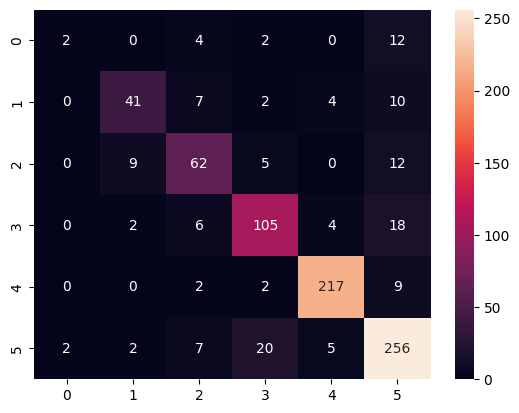

In [16]:
# Plotting Confusion Matrix

predictions = trainer.predict(test_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

print("\nLabel ID → Class Name Mapping:")
for idx, class_name in enumerate(le.classes_):
    print(f"{idx} : {class_name}")

In [ ]:
# Save the model and tokenizer

trainer.save_model("/content/drive/MyDrive/HCL Training Project/final_model")
tokenizer.save_pretrained("/content/drive/MyDrive/HCL Training Project/final_model")